In [1]:
import torch 
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

from attrdict import AttrDict
import numpy as np
import random

import matplotlib.pyplot as plt

In [2]:
args = AttrDict()
args.seeds = 1111

In [6]:
random_seed = args.seeds
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


## target problem: 1d nonlinear Poisson equation

In [7]:
#---------------------------------
# data configuration
#---------------------------------
dataconfig = AttrDict()

dataconfig.in_dim,dataconfig.out_dim  = 1,1
#dataconfig.noisestd = .5
#dataconfig.noisestd = 0.25
#dataconfig.noisestd = 0.1
dataconfig.noisestd = 0.01

#nb,nobs = 16,16 #(nsensors=16)

dataconfig.nb_train = 8
dataconfig.nb_val = 64
dataconfig.nb_te = 64
dataconfig.nb,dataconfig.nobs = dataconfig.nb_train,32 #(nsensors=32)

dataconfig.xmin,dataconfig.xmax = -0.7,0.7
dataconfig.tmin,dataconfig.tmax = 0,1

dataconfig

AttrDict({'in_dim': 1, 'out_dim': 1, 'noisestd': 0.01, 'nb_train': 8, 'nb_val': 64, 'nb_te': 64, 'nb': 8, 'nobs': 32, 'xmin': -0.7, 'xmax': 0.7, 'tmin': 0, 'tmax': 1})

In [9]:
def gen_obs(dataconfig,intrain = True):
    
    u = lambda x: torch.pow(torch.sin(6*x),3)
    f = lambda x: (6**3)*torch.sin(6*x)*torch.pow(torch.cos(6*x),2) - 3*(6**2)*torch.pow(torch.sin(6*x),3)
  
    # ----------------------------
    # gen datset on rd
    # ----------------------------    
    x = dataconfig.xmin  + (dataconfig.xmax  - dataconfig.xmin)* torch.rand(dataconfig.nb,dataconfig.nobs,dataconfig.in_dim )
    g_noise = dataconfig.noisestd*torch.randn(dataconfig.nb,dataconfig.nobs,dataconfig.in_dim )
    t = (dataconfig.tmax  - dataconfig.tmin)* torch.rand(dataconfig.nb,1,1 ).repeat(1,dataconfig.nobs,1)

    f_xt = f(x)
    y_rd = 0.01*f_xt + g_noise     
    xt_rd = torch.cat([x,t],dim=-1)
    u_xt = u(x)
    

    # ----------------------------
    # gen datset on init
    # ----------------------------    
    x = dataconfig.xmin  + (dataconfig.xmax  - dataconfig.xmin)* torch.rand(dataconfig.nb,dataconfig.nobs,dataconfig.in_dim )
    g_noise = dataconfig.noisestd*torch.randn(dataconfig.nb,dataconfig.nobs,dataconfig.in_dim )
    t = 0*torch.rand(dataconfig.nb,1,1 ).repeat(1,dataconfig.nobs,1)
    u_init = u(x)
    xt_init = torch.cat([x,t],dim=-1)

    # ----------------------------
    # gen datset on bd
    # ----------------------------    
    x = torch.cat([dataconfig.xmin* torch.ones(dataconfig.nb,dataconfig.nobs//2,dataconfig.in_dim ),
                   dataconfig.xmax* torch.ones(dataconfig.nb,dataconfig.nobs//2,dataconfig.in_dim )],dim=-2)
     
    #g_noise = dataconfig.noisestd*torch.randn(dataconfig.nb,dataconfig.nobs,dataconfig.in_dim )
    t = torch.rand(dataconfig.nb,dataconfig.nobs,1  )
    u_bd = u(x)
    #y_bd = u_bd      
    xt_bd = torch.cat([x,t],dim=-1)
    
    if intrain:
        return (xt_rd,y_rd,f_xt,u_xt),(xt_init,u_init),(xt_bd,u_bd)    
    else:
        return (xt_rd,y_rd,f_xt,u_xt),(xt_init,u_init),(xt_bd,u_bd), u    


        

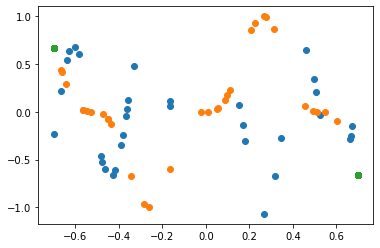

In [10]:
rd_set,init_set,bd_set = gen_obs(dataconfig)

xt_rd,y_rd,f,u_rd = rd_set
xt_init,u_init = init_set
xt_bd,u_bd = bd_set

bidx = 1
plt.scatter(xt_rd[bidx,:,0].cpu().data.numpy(),y_rd[bidx,:,0].cpu().data.numpy())
plt.scatter(xt_init[bidx,:,0].cpu().data.numpy(),u_init[bidx,:,0].cpu().data.numpy())
plt.scatter(xt_bd[bidx,:,0].cpu().data.numpy(),u_bd[bidx,:,0].cpu().data.numpy())

#plt.scatter(xt_init[:,0].cpu().data.numpy(),u_init[:,0].cpu().data.numpy())
# plt.scatter(xt[:,0].cpu().data.numpy(),f[:,0].cpu().data.numpy())


In [11]:
import copy
from models import PINN_SWAG,MLP_Layer
from models import PINN_BBB,BayesMLP_Layer
from models import PINN_MCdrop,MLP_Layer_MCdrop

def get_model(name = 'vi',config=AttrDict()):
    if name == 'swag':
        model = PINN_SWAG(MLP_Layer(in_dim = 1, out_dim=1) )
    elif name == 'vi':
        model = PINN_BBB(BayesMLP_Layer(in_dim = 1, out_dim=1))
    elif name == 'mcdrop01':
        model = PINN_MCdrop(MLP_Layer_MCdrop(in_dim = 1, out_dim=1,p=0.01))
    elif name == 'mcdrop05':   
        model = PINN_MCdrop(MLP_Layer_MCdrop(in_dim = 1, out_dim=1,p=0.05))
    else:
        pass
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr,weight_decay=config.weightdecay)
    return model,optimizer


def train_model(model,optimizer,dataconfig=AttrDict(),trainconfig=AttrDict()):

    dataconfig.nb = dataconfig.nb_val    
    rd_set_val,init_set_val,bd_set_val = gen_obs(dataconfig,intrain = True)
    
    model.train()
    best_loss = np.inf
    for j in range(1,trainconfig.nepochs+1):
        dataconfig.nb = dataconfig.nb_train        
        rd_set,init_set,bd_set = gen_obs(dataconfig)
        
        loss_rd,loss_init,loss_bd = model.compute_loss(*rd_set[:2],*init_set,*bd_set)


        if model.name == 'swag':
            loss = loss_rd + 0.5*(loss_init + loss_bd)         
            #update model params
            optimizer.zero_grad()        
            loss.backward()
            optimizer.step()

            if (trainconfig.start_nepochs <= j and
               (j - trainconfig.start_nepochs) % trainconfig.updateperiod== 0    ):
                print('update at {}'.format(j))
                model.collect_model()


            if j % trainconfig.obsperiod == 0:                
                #with torch.no_grad():
                loss_rd,loss_init,loss_bd = model.compute_loss(*rd_set_val[:2],*init_set_val,*bd_set_val)
                loss = loss_rd + 0.5*(loss_init + loss_bd)                             
                if loss.cpu().data.numpy() < best_loss:
                    best_loss = loss.cpu().data.numpy() 
                    best_state_dict = copy.deepcopy(model.state_dict())                        

                print('[swag: {} /{}]: tr loss: {:.2f} \t lossrd: {:.2f}, lossinit: {:.2f}, lossbd: {:.2f}, lossval: {:.2f}'.format(j,trainconfig.nepochs,loss,loss_rd,loss_init,loss_bd,best_loss))
                optimizer.zero_grad()        

        if model.name == 'vi':
            loss_data = loss_rd[0] + 0.5*(loss_init[0] + loss_bd[0]) 
            loss_reg = loss_rd[1] + 0.5*(loss_init[1] + loss_bd[1])
            loss = loss_data + trainconfig.bbb_reglambda*loss_reg

            #update model params
            optimizer.zero_grad()        
            loss.backward()
            optimizer.step()

            if j % trainconfig.obsperiod  == 0:                
                #with torch.no_grad():
                loss_rd,loss_init,loss_bd = model.compute_loss(*rd_set_val[:2],*init_set_val,*bd_set_val)
                loss =  loss_rd[0] + 0.5*(loss_init[0] + loss_bd[0])                            
                if loss.cpu().data.numpy() < best_loss:
                    best_loss = loss.cpu().data.numpy() 
                    best_state_dict = copy.deepcopy(model.state_dict())                        
                
                print('[vi: {} /{}]: loss {:.2f}, loss_data {:.2f}, reglam*loss_reg {:.2f}, loss_reg {:.2f}, lossval: {:.2f}'.format(j,trainconfig.nepochs,loss,loss_data,trainconfig.bbb_reglambda*loss_reg,loss_reg,best_loss))
                optimizer.zero_grad()        

        if model.name == 'mcdrop':
            loss = loss_rd[0] + 0.5*(loss_init[0] + loss_bd[0]) 

            #update model params
            optimizer.zero_grad()        
            loss.backward()
            optimizer.step()        

            if j % trainconfig.obsperiod  == 0:
                #with torch.no_grad():
                loss_rd,loss_init,loss_bd = model.compute_loss(*rd_set_val[:2],*init_set_val,*bd_set_val)
                loss = loss_rd[0] + 0.5*(loss_init[0] + loss_bd[0]) 
                if loss.cpu().data.numpy() < best_loss:
                    best_loss = loss.cpu().data.numpy() 
                    best_state_dict = copy.deepcopy(model.state_dict())                        
                
                print('[mcdrop: {} /{}]: tr loss: {:.2f} \t lossrd: {:.2f}, lossinit: {:.2f}, lossbd: {:.2f}, lossval: {:.2f}'.format(j,trainconfig.nepochs,loss,loss_rd[0],loss_init[0],loss_bd[0],best_loss))
                optimizer.zero_grad()        

    print('best param on validation set is loaded')
    model.load_state_dict(best_state_dict)                
    return model

/home/yohan/Myenv/Coursework/MAS408-Sience4machinelearning/models.py:45: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(module.weight)
/home/yohan/Myenv/Coursework/MAS408-Sience4machinelearning/models.py:297: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.W_mu.data)
/home/yohan/Myenv/Coursework/MAS408-Sience4machinelearning/models.py:556: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


In [ ]:
trainconfig = AttrDict()

trainconfig.nepochs = 2500
trainconfig.lr = 1e-3
trainconfig.weightdecay = 1e-4
trainconfig.obsperiod = 100

trainconfig.init_rate = .75
trainconfig.start_nepochs = int(trainconfig.nepochs*trainconfig.init_rate)
trainconfig.updateperiod = 50

#trainconfig.bbb_reglambda = 1e-4
trainconfig.bbb_reglambda = 5e-5



## train VI

In [13]:
model_vi,optimizer = get_model(name='vi',config=trainconfig)
model_vi = train_model(model_vi,optimizer,dataconfig=dataconfig,trainconfig=trainconfig)

/home/yohan/Myenv/Coursework/MAS408-Sience4machinelearning/models.py:297: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.W_mu.data)
/home/yohan/Myenv/lib/python3.6/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


[vi: 100 /2500]: loss 0.54, loss_data 0.55, reglam*loss_reg 0.07, loss_reg 1459.46, lossval: 0.54
[vi: 200 /2500]: loss 0.50, loss_data 0.50, reglam*loss_reg 0.06, loss_reg 1285.15, lossval: 0.50
[vi: 300 /2500]: loss 0.40, loss_data 0.40, reglam*loss_reg 0.07, loss_reg 1338.03, lossval: 0.40
[vi: 400 /2500]: loss 0.33, loss_data 0.30, reglam*loss_reg 0.07, loss_reg 1325.55, lossval: 0.33
[vi: 500 /2500]: loss 0.30, loss_data 0.31, reglam*loss_reg 0.06, loss_reg 1246.90, lossval: 0.30
[vi: 600 /2500]: loss 0.22, loss_data 0.22, reglam*loss_reg 0.07, loss_reg 1400.72, lossval: 0.22
[vi: 700 /2500]: loss 0.16, loss_data 0.18, reglam*loss_reg 0.08, loss_reg 1514.90, lossval: 0.16
[vi: 800 /2500]: loss 0.15, loss_data 0.16, reglam*loss_reg 0.07, loss_reg 1480.41, lossval: 0.15
[vi: 900 /2500]: loss 0.15, loss_data 0.16, reglam*loss_reg 0.07, loss_reg 1431.42, lossval: 0.15
[vi: 1000 /2500]: loss 0.15, loss_data 0.15, reglam*loss_reg 0.07, loss_reg 1398.90, lossval: 0.15
[vi: 1100 /2500]: l

## train MCdrop with p=0.01

In [14]:
model_mcdrop01,optimizer = get_model(name='mcdrop01',config=trainconfig)
model_mcdrop01 = train_model(model_mcdrop01,optimizer,dataconfig=dataconfig,trainconfig=trainconfig)

/home/yohan/Myenv/Coursework/MAS408-Sience4machinelearning/models.py:556: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
/home/yohan/Myenv/lib/python3.6/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


[mcdrop: 100 /2500]: tr loss: 0.55 	 lossrd: 0.34, lossinit: 0.38, lossbd: 0.06, lossval: 0.55
[mcdrop: 200 /2500]: tr loss: 0.51 	 lossrd: 0.34, lossinit: 0.31, lossbd: 0.04, lossval: 0.51
[mcdrop: 300 /2500]: tr loss: 0.34 	 lossrd: 0.30, lossinit: 0.05, lossbd: 0.02, lossval: 0.34
[mcdrop: 400 /2500]: tr loss: 0.26 	 lossrd: 0.23, lossinit: 0.04, lossbd: 0.02, lossval: 0.26
[mcdrop: 500 /2500]: tr loss: 0.13 	 lossrd: 0.10, lossinit: 0.04, lossbd: 0.02, lossval: 0.13
[mcdrop: 600 /2500]: tr loss: 0.11 	 lossrd: 0.09, lossinit: 0.03, lossbd: 0.02, lossval: 0.11
[mcdrop: 700 /2500]: tr loss: 0.11 	 lossrd: 0.08, lossinit: 0.03, lossbd: 0.02, lossval: 0.11
[mcdrop: 800 /2500]: tr loss: 0.10 	 lossrd: 0.08, lossinit: 0.02, lossbd: 0.02, lossval: 0.10
[mcdrop: 900 /2500]: tr loss: 0.10 	 lossrd: 0.07, lossinit: 0.02, lossbd: 0.02, lossval: 0.10
[mcdrop: 1000 /2500]: tr loss: 0.09 	 lossrd: 0.06, lossinit: 0.02, lossbd: 0.02, lossval: 0.09
[mcdrop: 1100 /2500]: tr loss: 0.08 	 lossrd: 0.0

## train SWAG

In [50]:
model_swag,optimizer = get_model(name='swag',config=trainconfig)
model_swag = train_model(model_swag,optimizer,dataconfig=dataconfig,trainconfig=trainconfig)

/home/yohan/Myenv/Coursework/MAS408-Sience4machinelearning/models.py:45: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(module.weight)
/home/yohan/Myenv/lib/python3.6/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


[swag: 100 /2500]: tr loss: 0.53 	 lossrd: 0.32, lossinit: 0.37, lossbd: 0.05, lossval: 0.53
[swag: 200 /2500]: tr loss: 0.46 	 lossrd: 0.32, lossinit: 0.23, lossbd: 0.05, lossval: 0.46
[swag: 300 /2500]: tr loss: 0.34 	 lossrd: 0.31, lossinit: 0.04, lossbd: 0.01, lossval: 0.34
[swag: 400 /2500]: tr loss: 0.32 	 lossrd: 0.30, lossinit: 0.03, lossbd: 0.00, lossval: 0.32
[swag: 500 /2500]: tr loss: 0.28 	 lossrd: 0.27, lossinit: 0.03, lossbd: 0.00, lossval: 0.28
[swag: 600 /2500]: tr loss: 0.23 	 lossrd: 0.22, lossinit: 0.02, lossbd: 0.00, lossval: 0.23
[swag: 700 /2500]: tr loss: 0.20 	 lossrd: 0.19, lossinit: 0.02, lossbd: 0.00, lossval: 0.20
[swag: 800 /2500]: tr loss: 0.15 	 lossrd: 0.14, lossinit: 0.01, lossbd: 0.00, lossval: 0.15
[swag: 900 /2500]: tr loss: 0.12 	 lossrd: 0.11, lossinit: 0.01, lossbd: 0.00, lossval: 0.12
[swag: 1000 /2500]: tr loss: 0.09 	 lossrd: 0.08, lossinit: 0.01, lossbd: 0.00, lossval: 0.09
[swag: 1100 /2500]: tr loss: 0.07 	 lossrd: 0.06, lossinit: 0.01, los

## Evaluate traied model

In [51]:
def sort_xy(x,y):
#     x_sorted,idx_sorted = torch.sort(xt_rd[j,:,0])
#     y_sorted = pred_mu[j,:,0][idx_sorted]
    x_sorted,idx_sorted = torch.sort(x)
    y_sorted = y[idx_sorted]
    return x_sorted.cpu().data.numpy(), y_sorted.cpu().data.numpy()

In [52]:
dataconfig.nb = dataconfig.nb_te
rd_set,init_set,bd_set,u_true = gen_obs(dataconfig,intrain=False)

xtrue = torch.linspace(-0.7,0.7,100)
utrue = u_true(xtrue)

xt_rd,y_rd,f,u_rd = rd_set
xt_init,u_init = init_set
xt_bd,u_bd = bd_set

## prediction

In [53]:
pred_mu0,pred_std0 = model_swag.compute_preddist(xt_rd,num_sample=20)

In [54]:
pred_mu1,pred_std1 = model_vi.compute_preddist(xt_rd,num_sample=20)

In [55]:
pred_mu2,pred_std2 = model_mcdrop01.compute_preddist(xt_rd,num_sample=20)

In [56]:
#pred_mu1

In [57]:
dist_list = [(pred_mu0,pred_std0,'swag'),(pred_mu1,pred_std1,'vi'),(pred_mu2,pred_std2,'mc01')]

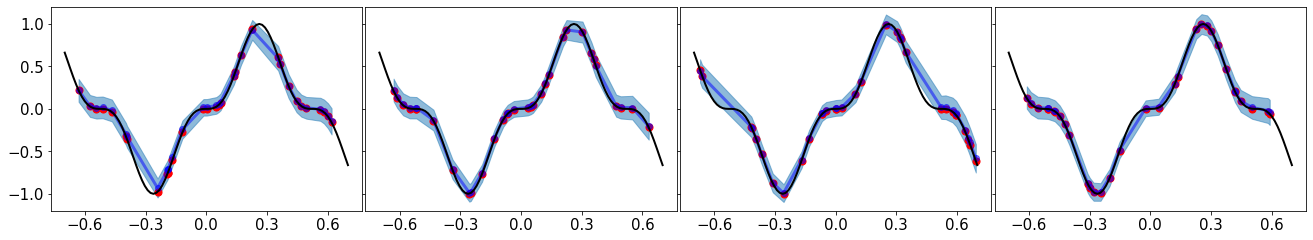

./fig/swag_noisestd0.01_saved




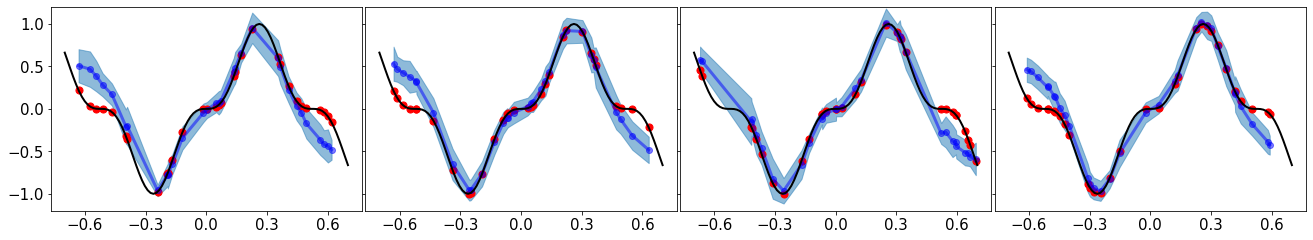

./fig/vi_noisestd0.01_saved




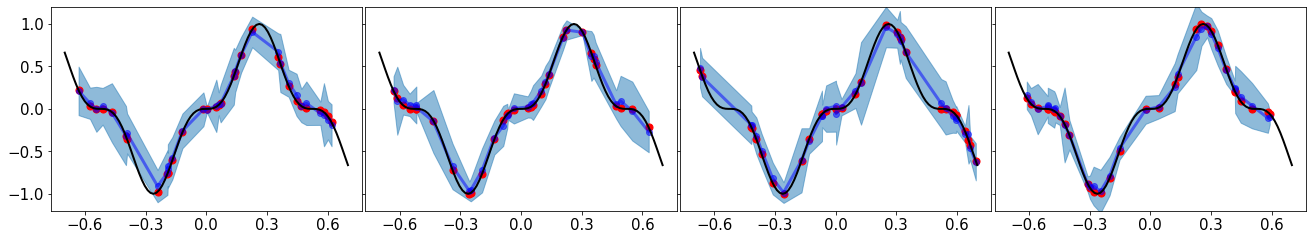

./fig/mc01_noisestd0.01_saved




In [58]:
#for x_rd,y_rd,u_rd in xt_rd,u:
#figure()
figconfig = AttrDict()
figconfig.figsiz = (22.5,3.75)


for pred_mu,pred_std,modelname in dist_list:
    fig,axes = plt.subplots(nrows=1,ncols=4,figsize = figconfig.figsiz,sharey=True)
    plt.subplots_adjust( wspace=0.01, hspace=0.01)
    for j in range(4):
        #pred_mean
        x,y = sort_xy( xt_rd[j,:,0],pred_mu[j,:,0] )
        axes[j].plot(x,y,'b-o',markersize=6, linewidth=3,alpha=0.5)

        #pred_2std
        x,y_l = sort_xy(xt_rd[j,:,0],(pred_mu-2*pred_std)[j,:,0])
        x,y_u = sort_xy(xt_rd[j,:,0],(pred_mu+2*pred_std)[j,:,0])
        axes[j].fill_between(x,y_l,y_u,color='tab:blue', alpha=0.5)                

        #true obs
        x,y = sort_xy( xt_rd[j,:,0],u_rd[j,:,0] )
        axes[j].scatter(x,y,s=50,color='r')

        #true func
        x,y = sort_xy( xtrue,utrue )    
        axes[j].plot(x,y,'k',linewidth=2.,alpha=1.)


        figconfig.fontsiz=15
        axes[j].set_xticks([-0.6,-0.3,0,0.3,0.6])
        axes[j].xaxis.set_tick_params(labelsize=figconfig.fontsiz)
        axes[j].yaxis.set_tick_params(labelsize=figconfig.fontsiz)


        #plt.xlim([-.7,.7])
        axes[j].set_ylim([-1.2,1.2])

    #savefigname = savefig_dir + datatype  + '_datav{}_dep{}_{}_ncontext{}_idx{}_together'.format(datav,str(dep).lower(), modelname ,ncontext,chosen_idx) 
    #print('savefigname: {}'.format(savefigname))
    savefigname = './fig/' + modelname + '_noisestd{}'.format(dataconfig.noisestd)
    plt.savefig(savefigname  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
    plt.show()
    print(savefigname + '_saved')
    print('\n')

    #plt.scatter(xt_rd[0,:,0].cpu().data.numpy(),f[0,:,0].cpu().data.numpy(),zorder=2)
#plt.scatter(xt_rd[1,:,0].cpu().data.numpy(),rd_set[2][1,:,0].cpu().data.numpy())

    
# for x_rd,y_rd,u_rd in xt_rd,u:
#     figure()
#     plt.scatter(xt_rd[0,:,0].cpu().data.numpy(),uxt_rd[1,:,0].cpu().data.numpy())
#     plt.scatter(xt_rd[1,:,0].cpu().data.numpy(),rd_set[2][1,:,0].cpu().data.numpy())


## compute metric: log Gaussian likelihood for empircal posterior distribution

In [61]:
for pred_mu,pred_std,modelname in dist_list:
    gauss_nll = nn.GaussianNLLLoss(reduction='none')
    score = -gauss_nll(u_rd,pred_mu,pred_std).cpu().data.numpy()
    
    mu_ll = score.mean().round(3)
    std_ll = score.std().round(3)
    print('method {}: \t mu_ll: {:.3f}, std_ll: {:.3f}'.format(modelname,mu_ll,std_ll))

method swag: 	 mu_ll: 1.404, std_ll: 0.074
method vi: 	 mu_ll: 1.102, std_ll: 0.330
method mc01: 	 mu_ll: 1.151, std_ll: 0.226


In [113]:
# #for x_rd,y_rd,u_rd in xt_rd,u:
    # #figure()
# figconfig = AttrDict()
# figconfig.figsiz = (22.5,4)

# #fig = plt.figure(figsize = figconfig.figsiz)
# #plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.2)

# fig,axes = plt.subplots(nrows=1,ncols=4,figsize = figconfig.figsiz,sharey=True)
# plt.subplots_adjust( wspace=0.01, hspace=0.01)


# for j in range(4):
#     #plt.subplot(1,4,j+1)
#     #plt.scatter(xt_rd[j,:,0].cpu().data.numpy(),uxt_rd[j,:,0].cpu().data.numpy(),color='b')
#     x,y = sort_xy( xt_rd[j,:,0],pred_mu[j,:,0] )
#     #plt.scatter(x,y,s=50,color='b')
#     #axes[j].plot(x,y,color='tab:blue',linestyle='-',marker='o',markersize=6, linewidth=2,alpha=0.9)
#     axes[j].plot(x,y,'b-o',markersize=6, linewidth=3,alpha=0.5)
    
#     x,y_l = sort_xy(xt_rd[j,:,0],(pred_mu-2*pred_std)[j,:,0])
#     x,y_u = sort_xy(xt_rd[j,:,0],(pred_mu+2*pred_std)[j,:,0])
#     axes[j].fill_between(x,y_l,y_u,color='tab:blue', alpha=0.5)                

    
#     x,y = sort_xy( xt_rd[j,:,0],u_rd[j,:,0] )
#     axes[j].scatter(x,y,s=50,color='r')
    
    
#     #if  j == 0:
#     x,y = sort_xy( xtrue,utrue )    
#     axes[j].plot(x,y,'k',linewidth=2.,alpha=1.)
    
        
#     figconfig.fontsiz=15
#     #axes[j].set_xtick(fontsize=figconfig.fontsiz)
#     #axes[j].set_ytick(fontsize=figconfig.fontsiz)
    
#     axes[j].set_xticks([-0.6,-0.3,0,0.3,0.6])
#     axes[j].xaxis.set_tick_params(labelsize=figconfig.fontsiz)
#     axes[j].yaxis.set_tick_params(labelsize=figconfig.fontsiz)
    

#     #plt.xlim([-.7,.7])
#     #axes[j].set_ylim([-1.7,1.7])
    
# #     plt.scatter(xt_init[j,:,0].cpu().data.numpy(),u_init[j,:,0].cpu().data.numpy(),color='r')
# #     plt.scatter(xt_bd[j,:,0].cpu().data.numpy(),u_bd[j,:,0].cpu().data.numpy())
    
# plt.show()
    
    
# #plt.scatter(xt_rd[0,:,0].cpu().data.numpy(),f[0,:,0].cpu().data.numpy(),zorder=2)
# #plt.scatter(xt_rd[1,:,0].cpu().data.numpy(),rd_set[2][1,:,0].cpu().data.numpy())

    
# # for x_rd,y_rd,u_rd in xt_rd,u:
# #     figure()
# #     plt.scatter(xt_rd[0,:,0].cpu().data.numpy(),uxt_rd[1,:,0].cpu().data.numpy())
# #     plt.scatter(xt_rd[1,:,0].cpu().data.numpy(),rd_set[2][1,:,0].cpu().data.numpy())


In [86]:
# #for x_rd,y_rd,u_rd in xt_rd,u:
# #figure()
# figconfig = AttrDict()
# figconfig.figsiz = (22,4)

# fig = plt.figure(figsize = figconfig.figsiz)
# #plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.2)
# plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.2)

# for j in range(4):
#     plt.subplot(1,4,j+1)
#     #plt.scatter(xt_rd[j,:,0].cpu().data.numpy(),uxt_rd[j,:,0].cpu().data.numpy(),color='b')
#     x,y = sort_xy( xt_rd[j,:,0],pred_mu[j,:,0] )
#     #plt.scatter(x,y,s=50,color='b')
#     plt.plot(x,y,'b-o',markersize=6, linewidth=2,alpha=0.9)
#     x,y_l = sort_xy(xt_rd[j,:,0],(pred_mu-2*pred_std)[j,:,0])
#     x,y_u = sort_xy(xt_rd[j,:,0],(pred_mu+2*pred_std)[j,:,0])
#     plt.fill_between(x,y_l,y_u,color='tab:blue', alpha=0.5)                

    
#     x,y = sort_xy( xt_rd[j,:,0],u_rd[j,:,0] )
#     plt.scatter(x,y,s=50,color='r')
    
    
#     #if  j == 0:
#     x,y = sort_xy( xtrue,utrue )    
#     plt.plot(x,y,'k',linewidth=2.,alpha=1.)
    
        
#     #plt.xlim([-.7,.7])
#     plt.ylim([-1.7,1.7])
#     figconfig.fontsiz=13
#     plt.xticks(fontsize=figconfig.fontsiz)
#     plt.yticks(fontsize=figconfig.fontsiz)
    
# #     plt.scatter(xt_init[j,:,0].cpu().data.numpy(),u_init[j,:,0].cpu().data.numpy(),color='r')
# #     plt.scatter(xt_bd[j,:,0].cpu().data.numpy(),u_bd[j,:,0].cpu().data.numpy())
    
# plt.show()
    
    
# #plt.scatter(xt_rd[0,:,0].cpu().data.numpy(),f[0,:,0].cpu().data.numpy(),zorder=2)
# #plt.scatter(xt_rd[1,:,0].cpu().data.numpy(),rd_set[2][1,:,0].cpu().data.numpy())

    
# # for x_rd,y_rd,u_rd in xt_rd,u:
# #     figure()
# #     plt.scatter(xt_rd[0,:,0].cpu().data.numpy(),uxt_rd[1,:,0].cpu().data.numpy())
# #     plt.scatter(xt_rd[1,:,0].cpu().data.numpy(),rd_set[2][1,:,0].cpu().data.numpy())


In [ ]:
# #for x_rd,y_rd,u_rd in xt_rd,u:
# #figure()
# for j in range(8):
#     #model.sample()
#     #uxt_rd = model(xt_rd)

#     fig = plt.figure()
#     #plt.scatter(xt_rd[j,:,0].cpu().data.numpy(),uxt_rd[j,:,0].cpu().data.numpy(),color='b')
#     x,y = sort_xy( xt_rd[j,:,0],pred_mu[j,:,0] )
#     #plt.scatter(x,y,s=50,color='b')
#     plt.plot(x,y,'b-o',markersize=5,linewidth=2,alpha=0.9)
#     x,y_l = sort_xy(xt_rd[j,:,0],(pred_mu-2*pred_std)[j,:,0])
#     x,y_u = sort_xy(xt_rd[j,:,0],(pred_mu+2*pred_std)[j,:,0])
#     plt.fill_between(x,y_l,y_u,color='tab:blue', alpha=0.5)                

    
#     x,y = sort_xy( xt_rd[j,:,0],u_rd[j,:,0] )
#     plt.scatter(x,y,s=50,color='r')
#     #plt.scatter(x,y,'r',markersize=5,linewidth=2,alpha=0.9)
    
        
#     #plt.xlim([-.7,.7])
#     plt.ylim([-1.7,1.7])
    
# #     plt.scatter(xt_init[j,:,0].cpu().data.numpy(),u_init[j,:,0].cpu().data.numpy(),color='r')
# #     plt.scatter(xt_bd[j,:,0].cpu().data.numpy(),u_bd[j,:,0].cpu().data.numpy())
    
#     plt.show()
    
    
# #plt.scatter(xt_rd[0,:,0].cpu().data.numpy(),f[0,:,0].cpu().data.numpy(),zorder=2)
# #plt.scatter(xt_rd[1,:,0].cpu().data.numpy(),rd_set[2][1,:,0].cpu().data.numpy())

    
# # for x_rd,y_rd,u_rd in xt_rd,u:
# #     figure()
# #     plt.scatter(xt_rd[0,:,0].cpu().data.numpy(),uxt_rd[1,:,0].cpu().data.numpy())
# #     plt.scatter(xt_rd[1,:,0].cpu().data.numpy(),rd_set[2][1,:,0].cpu().data.numpy())


In [86]:
#rd_set